In [117]:
# Importing the required libraries

import string
from pathlib import Path

import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import spmatrix, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.datasets import fetch_20newsgroups

In [2]:
def setup_libraries():
    nltk.download("stopwords")

In [3]:
def clean_data(X: np.array) -> np.array:
    X = np.vectorize(lambda x: x.lower())(X)
    # X = np.vectorize(lambda x: " ".join(x.split("\n\n")[1:]))(X)
    X = np.vectorize(lambda x: x.translate(str.maketrans("", "", string.punctuation)))(X)

    english_dict = set(nltk.corpus.words.words())
    stop_words = nltk.corpus.stopwords.words("english")
    X = np.vectorize(lambda x: " ".join([word for word in nltk.wordpunct_tokenize(x) if word not in stop_words and word in english_dict]))(X)

    return X

In [121]:
setup_libraries()

BASE_DIR = Path.cwd().parent
DATA_DIR = os.path.join(BASE_DIR, "data", "20news-bydate")

train_data = fetch_20newsgroups(
    data_home=DATA_DIR,
    subset="train"
)

X_train = np.array(train_data.data)
y_train = train_data.target

rand_idx = np.random.randint(X_train.shape[0])

X_train = clean_data(X_train)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
vectorizer.fit(X_train)

X_train_vectorized = vectorizer.transform(X_train)
print(f"Shape of X_train_vectorized = {X_train_vectorized.shape}")

del X_train

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kishore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape of X_train_vectorized = (11314, 10034)


In [103]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(points) -> np.array:
    distances = np.empty(shape=(points.shape[0], points.shape[0]), dtype=np.float16)

    chunk_size = 1000
    idx = 0

    for idx in tqdm(range(0, points.shape[0], chunk_size), desc="Calculating distance"):
        points_subset = points[idx : idx + chunk_size, :]
        
        distances[idx : idx + chunk_size, :] = cosine_similarity(points_subset, points)
        idx += chunk_size

    return distances

def create_neighbors(X: np.array, eps: float) -> pd.DataFrame:
    distance_matrix = get_cosine_similarity(X)

    print(f"distance_matrix max = {distance_matrix.max()}, distance_matrix min = {distance_matrix.min()}")
    # print(f"dist matrix mean = {distance_matrix.mean()}, std: {distance_matrix.std()}")

    df = pd.DataFrame()
    for idx in tqdm(range(distance_matrix.shape[0]), desc="Creating neighbors"):
        neighbors_array = np.where(distance_matrix[idx, :] >= eps)[0]
        
        df.loc[idx, "neighbors"] = ",".join(
            list(map(str, neighbors_array))
        )

        df.loc[idx, "num_neighbors"] = neighbors_array.shape[0]

        df.loc[idx, "pt"] = idx

    df = df.astype({"num_neighbors": int, "pt": int})

    df["cluster"] = np.nan
    
    return df

df = create_neighbors(X_train_vectorized, eps=0.1)

Calculating distance: 100%|█████████████████████| 12/12 [00:05<00:00,  2.30it/s]


distance_matrix max = 1.0, distance_matrix min = 0.0


Creating neighbors: 100%|███████████████| 11314/11314 [00:10<00:00, 1047.59it/s]


In [104]:
df

,neighbors,num_neighbors,pt,cluster
0,"0,17,29,30,48,77,84,156,262,492,564,571,592,59...",283,0,NaN
1,"1,169,174,178,368,374,450,685,704,714,1133,115...",77,1,NaN
2,"2,78,128,195,206,242,243,270,326,358,439,515,5...",234,2,NaN
3,"3,7,34,106,117,125,237,249,291,337,530,582,589...",294,3,NaN
4,"4,153,343,358,485,539,555,813,851,871,1007,122...",74,4,NaN
...,...,...,...,...
11309,"6,272,398,481,1220,1329,2058,2469,2811,2958,43...",26,11309,NaN
11310,"7,9,72,79,122,146,155,184,190,242,270,309,339,...",410,11310,NaN
11311,"663,2440,2597,2637,3185,4455,5720,6282,6701,72...",21,11311,NaN
11312,"12,171,373,478,584,632,752,1398,1729,2150,2208...",58,11312,NaN


In [85]:
class CustomDBSCAN:

    def __init__(self, eps: float, min_pts: int):
        self.eps = eps
        self.min_pts = min_pts

    
    def fit_predict(self, df: pd.DataFrame):        
        cluster_id = 0
        
        has_set_cluster = False
        num_points_without_cluster = df["cluster"].isna().sum()
        
        while num_points_without_cluster > 0:
            random_starting_point = df[df["cluster"].isna()].sample(n=1)

            queue = []
            queue.append(int(random_starting_point["pt"]))

            pts_visited = set()
            pts_visited.add(int(random_starting_point["pt"]))

            has_set_cluster = False

            while len(queue) > 0:
                point = queue.pop(0)

                # Setting the cluster id to this point
                if has_set_cluster or df[df["pt"] == point]["num_neighbors"].item() >= self.min_pts:
                    df.loc[df["pt"] == point, "cluster"] = cluster_id
            
                    # Adding all the neighbors to the queue
                    for neighbor in df[df["pt"] == point]["neighbors"].item().split(","):
                        if int(neighbor) not in pts_visited:
                            queue.append(int(neighbor))
                            pts_visited.add(int(neighbor))

                    has_set_cluster = True

                else:
                    df.loc[df["pt"] == point, "cluster"] = -1

            if has_set_cluster:
                cluster_id += 1

            num_points_without_cluster = df["cluster"].isna().sum()

        df["cluster"] = df["cluster"].astype(int)
        
        return df

In [105]:
dbscan = CustomDBSCAN(eps=0.1, min_pts=10)

In [106]:
result_df = dbscan.fit_predict(df.copy())

/tmp/ipykernel_17520/3812776189.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  queue.append(int(random_starting_point["pt"]))
/tmp/ipykernel_17520/3812776189.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pts_visited.add(int(random_starting_point["pt"]))


In [107]:
result_df.cluster.value_counts()

cluster
 0    11313
-1        1
Name: count, dtype: int64

In [108]:
result_df.cluster.nunique()

2

In [109]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardized_data = StandardScaler().fit_transform(X_train_vectorized)

pca = PCA(n_components=2, svd_solver="arpack")

pca_data = pca.fit_transform(X_train_vectorized)

In [110]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

In [111]:
percentage_var_explained

array([0.57610418, 0.42389582])

In [112]:
cum_var_explained

array([0.57610418, 1.        ])

In [113]:
pca_df = pd.DataFrame(pca_data, columns=["component_1", "component_2"])
pca_df["label"] = y_train
pca_df["cluster_label"] = result_df["cluster"]

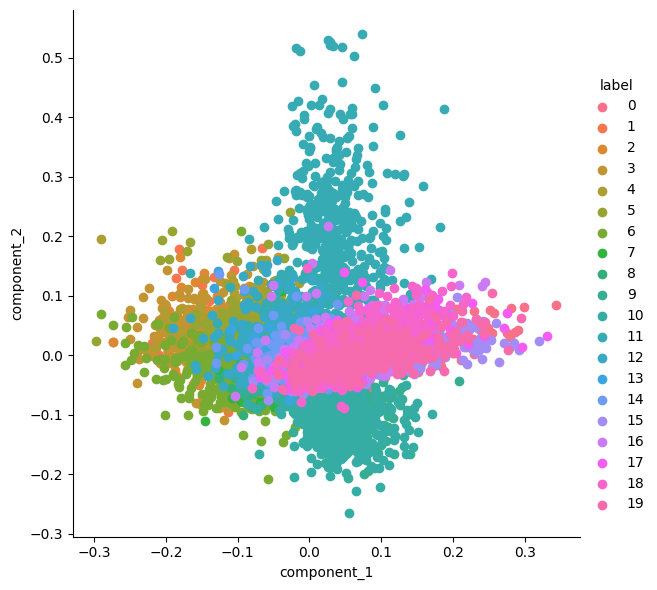

In [114]:
sn.FacetGrid(pca_df, hue='label', height=6).map(plt.scatter, 'component_1', 'component_2').add_legend()
plt.show()

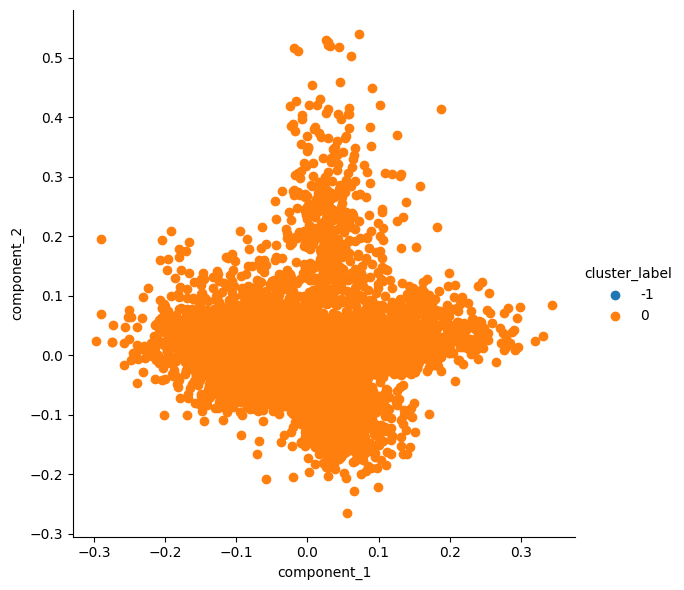

In [115]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.FacetGrid(pca_df, hue='cluster_label', height=6).map(plt.scatter, 'component_1', 'component_2').add_legend()
plt.show()